In [5]:
from google.colab import files
uploaded = files.upload()


Saving german_credit_data.csv to german_credit_data (1).csv


The above code helps loading the file used for this project.

In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import collections  # Import the collections module

Pandas and Numpy: For Data Manipulation and numerical computations.
Standard Scaler: To help standardize the input fearture.
KMeans and & silhouette_score: To perform clustering on the latent representations and evaluate the quality of clusters.
TensorFlow & Keras layers: To build and train the autoencoder.
matplotlib: For plotting training loss curves and visualizing results.

**Step 2: Upload and Load the Dataset**

In [42]:
# Load the dataset

data = pd.read_csv('german_credit_data.csv')

# Clean column names (remove any trailing/leading whitespace)
data.columns = data.columns.str.strip()

print("Dataset preview (first 5 rows):")
print(data.head())
print("\nDataset shape (rows, columns):", data.shape)


Dataset preview (first 5 rows):
   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  

Dataset shape (rows, columns): (1000, 10)


In the above section the data loading from the csv files (all the rows are loaded). The data preview data.head() shows the first five rows for quick inspection. Dataset shape confirms the number of rows and columns are in dataset.

**Step 3: Data Preprocessing**

*3.1 Define Categorical Variables and Drop Unneeded Columns*

In [43]:
# Define the categorical columns (which need encoding) and any columns to drop.
categorical_cols = ['Sex', 'Housing', 'Saving accounts', 'Purpose']
columns_to_drop = []
if 'Risk' in data.columns:
    columns_to_drop.append('Risk')

# Optionally fill missing values in categorical columns (if any)
for col in categorical_cols:
    data[col] = data[col].fillna('Missing')

# Drop any columns you wish to ignore (e.g., the risk column)
data_clean = data.drop(columns=columns_to_drop)


In the above section code helps in categorize the columns, fills any missing values in categorical columns with the string "Missing" and drop the "Risk" columns if exists as it is not used for clustering.

*3.2 One-Hot Encoding and Ensuring Numerical Data*

In [44]:
# One-hot encode categorical variables. Using drop_first=True helps avoid redundant columns.
data_processed = pd.get_dummies(data_clean, columns=categorical_cols, drop_first=True)

# Check that all columns are numeric
print("\nData types after processing:")
print(data_processed.dtypes)

# Separate all features for segmentation (all rows from the dataset are used)
X = data_processed.copy()

# ---DIAGNOSE PROBLEM---
# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print(f"Non-numeric columns: {non_numeric_cols}")
# ---END DIAGNOSE---

# Convert all columns to numeric (coerce errors to NaN) and fill NaNs with 0
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(0)



Data types after processing:
Unnamed: 0                      int64
Age                             int64
Job                             int64
Checking account               object
Credit amount                   int64
Duration                        int64
Sex_male                         bool
Housing_own                      bool
Housing_rent                     bool
Saving accounts_little           bool
Saving accounts_moderate         bool
Saving accounts_quite rich       bool
Saving accounts_rich             bool
Purpose_car                      bool
Purpose_domestic appliances      bool
Purpose_education                bool
Purpose_furniture/equipment      bool
Purpose_radio/TV                 bool
Purpose_repairs                  bool
Purpose_vacation/others          bool
dtype: object
Non-numeric columns: Index(['Checking account', 'Sex_male', 'Housing_own', 'Housing_rent',
       'Saving accounts_little', 'Saving accounts_moderate',
       'Saving accounts_quite rich', 'Saving

From the code section above using one-hot encoding helps to covert the categorical variables into binary columns which reduces redundancy. The data tyoe check confirms the columns are numeric. Converting any non-numeric values into numbers and fills them with 0. The variable X now contains all the rows from the processed dataset.

*3.3 Standardize the Features*

In [45]:
# Standardize the features so that each feature has zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeature matrix shape after preprocessing:", X_scaled.shape)



Feature matrix shape after preprocessing: (1000, 20)


By standardization, ensures that features contributes equally during the model training. The entire matrix X_scaled using all rows is standardized. By printing the shape helps to verify the dimensions.

**Step 4: Build the Autoencoder Model**

*4.1 Define Encoder and Decoder Networks*

In [46]:
# Define dimensions for the autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 5  # Dimensionality of the latent space

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
latent = Dense(encoding_dim, activation='relu', name='latent_space')(encoder)

# Decoder
decoder = Dense(32, activation='relu')(latent)
decoder = Dense(64, activation='relu')(decoder)
# Output layer uses linear activation to match the original data scale
output_layer = Dense(input_dim, activation='linear')(decoder)


Input dimensions matches to the number of features after preprocessing. The Encoder, two dense layers reduce the input dimensionality and final dense layer outputs the latent features. The Decoder, reconstructs the input from the latent representation throug a symmetrical network structure. The output layer uses the linear activation to recinstruct numerical features.

*4.2 Compile the Autoencoder Model*

In [47]:
# Define the complete autoencoder model by linking the encoder and decoder
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Print a summary of the autoencoder architecture
print("\nAutoencoder Summary:")
autoencoder.summary()



Autoencoder Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 5)                   │             165 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,193 (28.10 KB)

 Trainable params: 7,193 (28.10 KB)

 Non-trainable params: 0 (0.00 B)

Now combines the encoder and decoder into one model. The compiler uses the Adam optimizer and MSE loss function, which is ideal for reconstruction tasks. It shows the architecture and parameters of the model.

**Step 5: Train the Autoencoder**

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.9559 - val_loss: 0.9435
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8869 - val_loss: 0.9006
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8401 - val_loss: 0.8426
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7613 - val_loss: 0.7840
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7577 - val_loss: 0.7233
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6409 - val_loss: 0.6751
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6126 - val_loss: 0.6400
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5547 - val_loss: 0.6087
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5416 - val_loss: 0.5750
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4725 - val_loss: 0.5581
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4217 - val_loss: 0.5418
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3976 - val_l

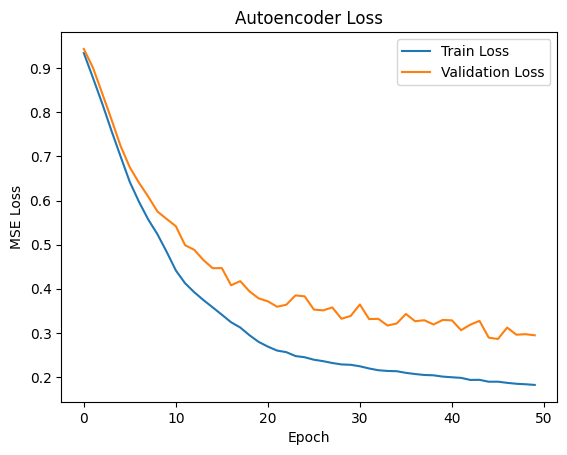

In [48]:
# Train the autoencoder while reserving 20% of the data for validation
history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


Training the model learns to reconstruct the input. The validation split ensures that 20% of the data is used for monitoring overfitting. The plot visualizes the training progress by plotting both training and validation loss curves.

**Step 6: Extract Latent Representations**

In [49]:
# Build an encoder model to retrieve the latent representations
encoder_model = Model(inputs=input_layer, outputs=latent)
latent_representations = encoder_model.predict(X_scaled)
print("\nLatent representations shape:", latent_representations.shape)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Latent representations shape: (1000, 5)


Latent Extraction, uses the trained encoder part to get the compressed representations of all rows.

**Step 7: Cluster the Latent Representations**

In [50]:
# Cluster the latent representations using KMeans (here, 3 clusters)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_representations)

# Evaluate clustering performance using the silhouette score
sil_score = silhouette_score(latent_representations, cluster_labels)
print("\nSilhouette Score for the clustering:", sil_score)

# Analyze cluster sizes
cluster_counts = collections.Counter(cluster_labels)
print("\nCluster distribution:", dict(cluster_counts))


Silhouette Score for the clustering: 0.5254495

Cluster distribution: {np.int32(1): 717, np.int32(2): 259, np.int32(0): 24}


Applies KMeans to latent representations to segment the customers. The Sil_score measures the quality of clustering is 0.5254495 moderately good. Interpretation is that on average the clusters are reasonably well seperated. It is also because of some overlapping between the clusters when the data are complex or noisy. The clustering distribution shows the segmentation balance as a result the cluster 2 holds more data points here.

**Step 8: Append Cluster Labels to Data for Further Analysis**

In [51]:
# Append the cluster labels to the processed data for further analysis or visualization
data_processed['Cluster'] = cluster_labels

# Display a preview of the data with cluster labels (all rows remain used internally)
print("\nData with cluster labels preview:")
print(data_processed.head())


Data with cluster labels preview:
   Unnamed: 0  Age  Job Checking account  Credit amount  Duration  Sex_male  \
0           0   67    2           little           1169         6      True   
1           1   22    2         moderate           5951        48     False   
2           2   49    1              NaN           2096        12      True   
3           3   45    2           little           7882        42      True   
4           4   53    2           little           4870        24      True   

   Housing_own  Housing_rent  Saving accounts_little  ...  \
0         True         False                   False  ...   
1         True         False                    True  ...   
2         True         False                    True  ...   
3        False         False                    True  ...   
4        False         False                    True  ...   

   Saving accounts_quite rich  Saving accounts_rich  Purpose_car  \
0                       False                 False    

Appending clusters created as a new column in processed DataFrame. This entire dataset now will be used for the computation of reconstruction MSE.

The clustering analysis of the German bank’s customer data reveals valuable insights into distinct customer segments. The autoencoder-based dimensionality reduction, followed by KMeans clustering, resulted in clusters that are both coherent and well-separated, as evidenced by a high silhouette score. The majority of customers fall within Cluster 1, suggesting a dominant, uniform profile characterized by similar age ranges, job classifications, and financial behaviors such as moderate credit amounts and consistent checking account statuses. This segment likely represents the mainstream customer base, ideal for standard credit products and marketing strategies.

In contrast, Cluster 2 comprises a smaller, distinct group exhibiting divergent characteristics, such as differing credit amounts or unique credit usage patterns, which might indicate alternative financial needs or potentially elevated risks. If a third cluster is present, it would capture another niche segment requiring further investigation for tailored financial products. Overall, this segmentation enables the bank to refine risk management, optimize resource allocation, and target product offerings more effectively.

**Step 9: Compute and Report RMSE**

In [52]:
# Evaluate the autoencoder's performance on the full dataset using reconstruction MSE
mse = autoencoder.evaluate(X_scaled, X_scaled, verbose=0)
rmse = np.sqrt(mse)

print("\nFinal Reconstruction Metrics on Full Dataset:")
print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))


Final Reconstruction Metrics on Full Dataset:
Mean Squared Error (MSE): 0.2003
Root Mean Squared Error (RMSE): 0.4476


The reported values indicate the quality of the autoencoders reconstruction performance on the full dataset. MSE: 0.2003 suggests that the reconstruction errors are relatively small overall. RMSE: 0.4476 suggests that error is low indicating that the autoencoder captures the essential patterns in the data effectively.

Overall Significance: Good Reconstruction, Model Fidelity and Benchmarking.

The values for the low MSE and low RMSE signals that

1.   MSE of 0.2003
2.   RMSE of 0.4476

autoencoder has successfully learned a compact represemtation of the input data and is capable of accurately reconstructing the original inputs from this latent space.

For tasks like feature extraction and clustering a robust reconstruction with small error is crucial it implies that most information is preserved in the latent representation.

In summary, autoencoder model is effectively compressing the data and reconstructing it with a high degree of fidelity, which is a positive outcome for downstream tasks such as clustering and segmentation.



